In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import plotly.express as px
from sklearn.model_selection import train_test_split, KFold, cross_validate, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score,f1_score

In [2]:
df = pd.read_csv('hotel_bookings.csv')
df

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.00,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.00,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,...,No Deposit,NaN,NaN,0,Transient,75.00,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,...,No Deposit,304.0,NaN,0,Transient,75.00,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,No Deposit,240.0,NaN,0,Transient,98.00,0,1,Check-Out,2015-07-03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119385,City Hotel,0,23,2017,August,35,30,2,5,2,...,No Deposit,394.0,NaN,0,Transient,96.14,0,0,Check-Out,2017-09-06
119386,City Hotel,0,102,2017,August,35,31,2,5,3,...,No Deposit,9.0,NaN,0,Transient,225.43,0,2,Check-Out,2017-09-07
119387,City Hotel,0,34,2017,August,35,31,2,5,2,...,No Deposit,9.0,NaN,0,Transient,157.71,0,4,Check-Out,2017-09-07
119388,City Hotel,0,109,2017,August,35,31,2,5,2,...,No Deposit,89.0,NaN,0,Transient,104.40,0,0,Check-Out,2017-09-07


In [3]:
df.isnull().sum()

hotel                                  0
is_canceled                            0
lead_time                              0
arrival_date_year                      0
arrival_date_month                     0
arrival_date_week_number               0
arrival_date_day_of_month              0
stays_in_weekend_nights                0
stays_in_week_nights                   0
adults                                 0
children                               4
babies                                 0
meal                                   0
country                              488
market_segment                         0
distribution_channel                   0
is_repeated_guest                      0
previous_cancellations                 0
previous_bookings_not_canceled         0
reserved_room_type                     0
assigned_room_type                     0
booking_changes                        0
deposit_type                           0
agent                              16340
company         

In [4]:
replace = {"children:": 0.0,"country": "Unknown", "agent": 0, "company": 0}
df1 = df.fillna(replace)

In [5]:
df1.drop(df1.loc[df['adults']+df['children']+df['babies']==0].index,inplace=True)

In [6]:
df1.shape

(119210, 32)

In [7]:
resort = df1.loc[(df1["hotel"] == "Resort Hotel") & (df1["is_canceled"] == 0)]
city = df1.loc[(df1["hotel"] == "City Hotel") & (df1["is_canceled"] == 0)]

In [8]:
ms=df1["market_segment"].value_counts()
ms

Online TA        56408
Offline TA/TO    24182
Groups           19791
Direct           12582
Corporate         5282
Complementary      728
Aviation           235
Undefined            2
Name: market_segment, dtype: int64

fig = px.pie(segments,
             values=segments.values,
             names=segments.index,
             title="Bookings per market segment",
             template="seaborn")
fig.update_traces(rotation=-90, textinfo="percent+label")
fig.show()

In [9]:
lab = ['Online TA', 'Offline TA/TO','Groups','Direct','Corporate','Complementary','Aviation','Undefined'] 

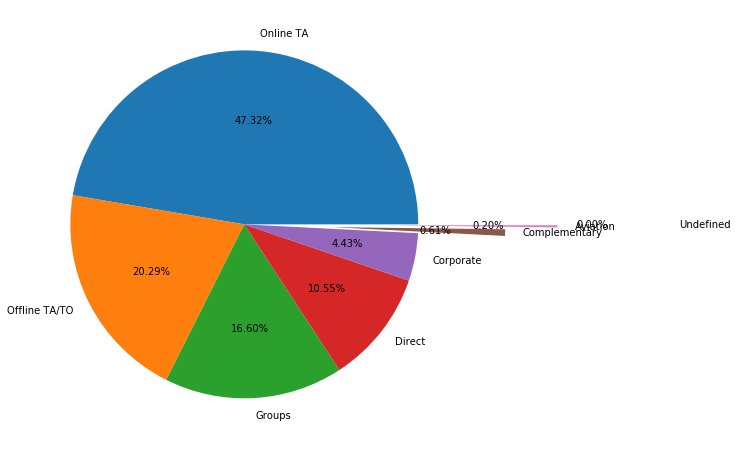

In [10]:
plt.figure(figsize=(15,8))
plt.pie(ms,autopct='%1.2f%%',explode=[0,0,0,0,0,0.5,0.8,1.4],labels=lab)
plt.show()

In [11]:
total_cancels = df1["is_canceled"].sum()
resort_cancels = df1.loc[df1["hotel"] == "Resort Hotel"]["is_canceled"].sum()
city_cancels = df1.loc[df1["hotel"] == "City Hotel"]["is_canceled"].sum()

cancel_per = (total_cancels / df1.shape[0]) * 100
rh_cancel_per = (resort_cancels / df1.loc[df1["hotel"] == "Resort Hotel"].shape[0]) * 100
ch_cancel_per = (city_cancels / df1.loc[df1["hotel"] == "City Hotel"].shape[0]) * 100

print(f"Total bookings canceled: {total_cancels:,} ({cancel_per:.0f} %)")
print(f"Resort hotel bookings canceled: {resort_cancels:,} ({rh_cancel_per:.0f} %)")
print(f"City hotel bookings canceled: {city_cancels:,} ({ch_cancel_per:.0f} %)")

Total bookings canceled: 44,199 (37 %)
Resort hotel bookings canceled: 11,120 (28 %)
City hotel bookings canceled: 33,079 (42 %)


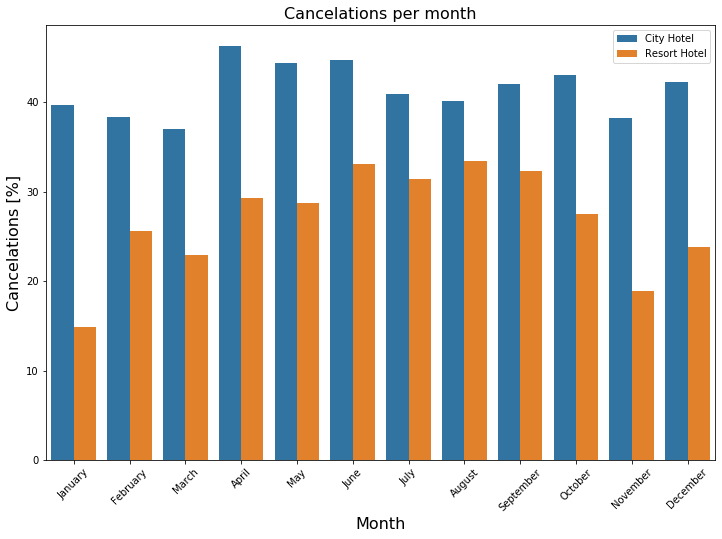

In [12]:
rbook_per_month = df1.loc[(df1["hotel"] == "Resort Hotel")].groupby("arrival_date_month")["hotel"].count()
rcancel_per_month = df1.loc[(df1["hotel"] == "Resort Hotel")].groupby("arrival_date_month")["is_canceled"].sum()

cbook_per_month = df1.loc[(df1["hotel"] == "City Hotel")].groupby("arrival_date_month")["hotel"].count()
ccancel_per_month = df1.loc[(df1["hotel"] == "City Hotel")].groupby("arrival_date_month")["is_canceled"].sum()

rcancel = pd.DataFrame({"Hotel": "Resort Hotel",
                                "Month": list(rbook_per_month.index),
                                "Bookings": list(rbook_per_month.values),
                                "Cancelations": list(rcancel_per_month.values)})
ccancel = pd.DataFrame({"Hotel": "City Hotel",
                                "Month": list(cbook_per_month.index),
                                "Bookings": list(cbook_per_month.values),
                                "Cancelations": list(ccancel_per_month.values)})

full_cancel_data = pd.concat([rcancel, ccancel], ignore_index=True)
full_cancel_data["cancel_percent"] = full_cancel_data["Cancelations"] / full_cancel_data["Bookings"] * 100

ordered_months = ["January", "February", "March", "April", "May", "June", 
          "July", "August", "September", "October", "November", "December"]
full_cancel_data["Month"] = pd.Categorical(full_cancel_data["Month"], categories=ordered_months, ordered=True)

# show figure:
plt.figure(figsize=(12, 8))
sns.barplot(x = "Month", y = "cancel_percent" , hue="Hotel",
            hue_order = ["City Hotel", "Resort Hotel"], data=full_cancel_data)
plt.title("Cancelations per month", fontsize=16)
plt.xlabel("Month", fontsize=16)
plt.xticks(rotation=45)
plt.ylabel("Cancelations [%]", fontsize=16)
plt.legend(loc="upper right")
plt.show()

In [13]:
cancel_corr = df.corr()["is_canceled"]
cancel_corr.abs().sort_values(ascending=False)[1:]

lead_time                         0.293123
total_of_special_requests         0.234658
required_car_parking_spaces       0.195498
booking_changes                   0.144381
previous_cancellations            0.110133
is_repeated_guest                 0.084793
agent                             0.083114
adults                            0.060017
previous_bookings_not_canceled    0.057358
days_in_waiting_list              0.054186
adr                               0.047557
babies                            0.032491
stays_in_week_nights              0.024765
company                           0.020642
arrival_date_year                 0.016660
arrival_date_week_number          0.008148
arrival_date_day_of_month         0.006130
children                          0.005048
stays_in_weekend_nights           0.001791
Name: is_canceled, dtype: float64

In [14]:
df.groupby("is_canceled")["reservation_status"].value_counts()

is_canceled  reservation_status
0            Check-Out             75166
1            Canceled              43017
             No-Show                1207
Name: reservation_status, dtype: int64

In [15]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,BaggingClassifier,AdaBoostClassifier,GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier


In [16]:
df1.isnull().sum()

hotel                             0
is_canceled                       0
lead_time                         0
arrival_date_year                 0
arrival_date_month                0
arrival_date_week_number          0
arrival_date_day_of_month         0
stays_in_weekend_nights           0
stays_in_week_nights              0
adults                            0
children                          4
babies                            0
meal                              0
country                           0
market_segment                    0
distribution_channel              0
is_repeated_guest                 0
previous_cancellations            0
previous_bookings_not_canceled    0
reserved_room_type                0
assigned_room_type                0
booking_changes                   0
deposit_type                      0
agent                             0
company                           0
days_in_waiting_list              0
customer_type                     0
adr                         

In [17]:
df1['children'].fillna(df1['children'].median(),inplace=True)

In [18]:
df1.isnull().sum()

hotel                             0
is_canceled                       0
lead_time                         0
arrival_date_year                 0
arrival_date_month                0
arrival_date_week_number          0
arrival_date_day_of_month         0
stays_in_weekend_nights           0
stays_in_week_nights              0
adults                            0
children                          0
babies                            0
meal                              0
country                           0
market_segment                    0
distribution_channel              0
is_repeated_guest                 0
previous_cancellations            0
previous_bookings_not_canceled    0
reserved_room_type                0
assigned_room_type                0
booking_changes                   0
deposit_type                      0
agent                             0
company                           0
days_in_waiting_list              0
customer_type                     0
adr                         

In [27]:
df1 = df1.drop_duplicates()

In [28]:
y = df1["is_canceled"]
X = df1.drop(["is_canceled"], axis=1)

x_train, x_test, y_train, y_test = train_test_split(X, y,test_size=0.3, random_state=0)


num_features = ["lead_time","arrival_date_week_number","arrival_date_day_of_month",
                "stays_in_weekend_nights","stays_in_week_nights","adults","children",
                "babies","is_repeated_guest", "previous_cancellations",
                "previous_bookings_not_canceled","agent","company",
                "required_car_parking_spaces", "total_of_special_requests", "adr"]

cat_features = ["hotel","arrival_date_month","meal","market_segment",
                "distribution_channel","reserved_room_type","deposit_type","customer_type"]

x_train = x_train[num_features + cat_features].copy()
x_test = x_test[num_features + cat_features].copy()

num_transformer = SimpleImputer(strategy="constant")


cat_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="constant", fill_value="Unknown")),
    ("onehot", OneHotEncoder(handle_unknown='ignore'))])


preprocessor = ColumnTransformer(transformers=[('num', num_transformer, num_features),
                                               ('cat', cat_transformer, cat_features)])

In [29]:
from xgboost import XGBClassifier

model = XGBClassifier(max_depth=5, learning_rate=0.1, n_estimators=1000, gamma=0, 
                        min_child_weight=1, subsample=0.8, colsample_bytree=0.8, reg_alpha=0.005,random_state=101)
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('model', model)])

pipeline.fit(x_train, y_train)


predictions = pipeline.predict(x_test)

from sklearn.metrics import classification_report
from sklearn import metrics

# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

print(classification_report(y_test,predictions))

confusion_matrix=metrics.confusion_matrix(y_test,predictions)

sensitivity = confusion_matrix[0,0]/(confusion_matrix[0,0]+confusion_matrix[1,0])

specificity = confusion_matrix[1,1]/(confusion_matrix[1,1]+confusion_matrix[0,1])

precision = confusion_matrix[0,0]/(confusion_matrix[0,0]+confusion_matrix[0,1])

f1_score = (2*sensitivity*precision)/(sensitivity+precision)
print('f1_score1 :% .2f '% f1_score)

Accuracy: 81.61%
              precision    recall  f1-score   support

           0       0.84      0.92      0.88     18979
           1       0.72      0.55      0.62      7190

    accuracy                           0.82     26169
   macro avg       0.78      0.73      0.75     26169
weighted avg       0.81      0.82      0.81     26169

f1_score1 : 0.88 


In [30]:
model = KNeighborsClassifier(n_neighbors=5,
    weights='uniform',
    algorithm='auto',
    leaf_size=30,
    p=2,
    metric='minkowski')
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('model', model)])

pipeline.fit(x_train, y_train)


predictions = pipeline.predict(x_test)

from sklearn.metrics import classification_report
from sklearn import metrics

# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

print(classification_report(y_test,predictions))

confusion_matrix=metrics.confusion_matrix(y_test,predictions)

sensitivity = confusion_matrix[0,0]/(confusion_matrix[0,0]+confusion_matrix[1,0])

specificity = confusion_matrix[1,1]/(confusion_matrix[1,1]+confusion_matrix[0,1])

precision = confusion_matrix[0,0]/(confusion_matrix[0,0]+confusion_matrix[0,1])

f1_score = (2*sensitivity*precision)/(sensitivity+precision)
print('f1_score :% .2f '% f1_score)

Accuracy: 71.33%
              precision    recall  f1-score   support

           0       0.78      0.85      0.81     18979
           1       0.47      0.36      0.41      7190

    accuracy                           0.71     26169
   macro avg       0.62      0.60      0.61     26169
weighted avg       0.69      0.71      0.70     26169

f1_score : 0.81 


In [31]:
model = DecisionTreeClassifier(criterion='gini',
    splitter='best',
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    min_weight_fraction_leaf=0.0,
    max_features=None,
    random_state=None,
    max_leaf_nodes=None,
    min_impurity_decrease=0.0,
    min_impurity_split=None,
    class_weight=None,
    presort='deprecated',
    ccp_alpha=0.0)
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('model', model)])

pipeline.fit(x_train, y_train)


predictions = pipeline.predict(x_test)

from sklearn.metrics import classification_report
from sklearn import metrics

# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

print(classification_report(y_test,predictions))

confusion_matrix=metrics.confusion_matrix(y_test,predictions)

sensitivity = confusion_matrix[0,0]/(confusion_matrix[0,0]+confusion_matrix[1,0])

specificity = confusion_matrix[1,1]/(confusion_matrix[1,1]+confusion_matrix[0,1])

precision = confusion_matrix[0,0]/(confusion_matrix[0,0]+confusion_matrix[0,1])

f1_score = (2*sensitivity*precision)/(sensitivity+precision)
print('f1_score :% .2f '% f1_score)

Accuracy: 75.00%
              precision    recall  f1-score   support

           0       0.83      0.82      0.83     18979
           1       0.54      0.56      0.55      7190

    accuracy                           0.75     26169
   macro avg       0.69      0.69      0.69     26169
weighted avg       0.75      0.75      0.75     26169

f1_score : 0.83 


In [32]:
model = RandomForestClassifier(n_estimators=100,
    criterion='gini',
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    min_weight_fraction_leaf=0.0,
    max_features='auto',
    max_leaf_nodes=None,
    min_impurity_decrease=0.0,
    min_impurity_split=None,
    bootstrap=True,
    oob_score=False,
    n_jobs=None,
    random_state=None,
    verbose=0,
    warm_start=False,
    class_weight=None,
    ccp_alpha=0.0,
    max_samples=None)
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('model', model)])

pipeline.fit(x_train, y_train)


predictions = pipeline.predict(x_test)

from sklearn.metrics import classification_report
from sklearn import metrics

# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

print(classification_report(y_test,predictions))

confusion_matrix=metrics.confusion_matrix(y_test,predictions)

sensitivity = confusion_matrix[0,0]/(confusion_matrix[0,0]+confusion_matrix[1,0])

specificity = confusion_matrix[1,1]/(confusion_matrix[1,1]+confusion_matrix[0,1])

precision = confusion_matrix[0,0]/(confusion_matrix[0,0]+confusion_matrix[0,1])

f1_score = (2*sensitivity*precision)/(sensitivity+precision)
print('f1_score :% .2f '% f1_score)

Accuracy: 81.39%
              precision    recall  f1-score   support

           0       0.84      0.92      0.88     18979
           1       0.71      0.54      0.62      7190

    accuracy                           0.81     26169
   macro avg       0.78      0.73      0.75     26169
weighted avg       0.81      0.81      0.81     26169

f1_score : 0.88 


In [33]:
model = BaggingClassifier(base_estimator=None,
    n_estimators=10,
    max_samples=1.0,
    max_features=1.0,
    bootstrap=True,
    bootstrap_features=False,
    oob_score=False,
    warm_start=False,
    n_jobs=None,
    random_state=None,
    verbose=0)
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('model', model)])

pipeline.fit(x_train, y_train)


predictions = pipeline.predict(x_test)

from sklearn.metrics import classification_report
from sklearn import metrics

# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

print(classification_report(y_test,predictions))

confusion_matrix=metrics.confusion_matrix(y_test,predictions)

sensitivity = confusion_matrix[0,0]/(confusion_matrix[0,0]+confusion_matrix[1,0])

specificity = confusion_matrix[1,1]/(confusion_matrix[1,1]+confusion_matrix[0,1])

precision = confusion_matrix[0,0]/(confusion_matrix[0,0]+confusion_matrix[0,1])

f1_score = (2*sensitivity*precision)/(sensitivity+precision)
print('f1_score :% .2f '% f1_score)

Accuracy: 79.97%
              precision    recall  f1-score   support

           0       0.83      0.91      0.87     18979
           1       0.68      0.52      0.59      7190

    accuracy                           0.80     26169
   macro avg       0.75      0.71      0.73     26169
weighted avg       0.79      0.80      0.79     26169

f1_score : 0.87 


In [34]:
model = AdaBoostClassifier(base_estimator=None,
    n_estimators=50,
    learning_rate=1.0,
    algorithm='SAMME.R',
    random_state=None)
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('model', model)])

pipeline.fit(x_train, y_train)


predictions = pipeline.predict(x_test)

from sklearn.metrics import classification_report
from sklearn import metrics

# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

print(classification_report(y_test,predictions))

confusion_matrix=metrics.confusion_matrix(y_test,predictions)

sensitivity = confusion_matrix[0,0]/(confusion_matrix[0,0]+confusion_matrix[1,0])

specificity = confusion_matrix[1,1]/(confusion_matrix[1,1]+confusion_matrix[0,1])

precision = confusion_matrix[0,0]/(confusion_matrix[0,0]+confusion_matrix[0,1])

f1_score = (2*sensitivity*precision)/(sensitivity+precision)
print('f1_score :% .2f '% f1_score)

Accuracy: 80.36%
              precision    recall  f1-score   support

           0       0.82      0.93      0.87     18979
           1       0.73      0.46      0.56      7190

    accuracy                           0.80     26169
   macro avg       0.77      0.70      0.72     26169
weighted avg       0.79      0.80      0.79     26169

f1_score : 0.87 


In [35]:
model = GradientBoostingClassifier(loss='deviance',
    learning_rate=0.1,
    n_estimators=100,
    subsample=1.0,
    criterion='friedman_mse',
    min_samples_split=2,
    min_samples_leaf=1,
    min_weight_fraction_leaf=0.0,
    max_depth=3,
    min_impurity_decrease=0.0,
    min_impurity_split=None,
    init=None,
    random_state=None,
    max_features=None,
    verbose=0,
    max_leaf_nodes=None,
    warm_start=False,
    presort='deprecated',
    validation_fraction=0.1,
    n_iter_no_change=None,
    tol=0.0001,
    ccp_alpha=0.0)
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('model', model)])

pipeline.fit(x_train, y_train)


predictions = pipeline.predict(x_test)

from sklearn.metrics import classification_report
from sklearn import metrics

accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

print(classification_report(y_test,predictions))

confusion_matrix=metrics.confusion_matrix(y_test,predictions)

sensitivity = confusion_matrix[0,0]/(confusion_matrix[0,0]+confusion_matrix[1,0])

specificity = confusion_matrix[1,1]/(confusion_matrix[1,1]+confusion_matrix[0,1])

precision = confusion_matrix[0,0]/(confusion_matrix[0,0]+confusion_matrix[0,1])

f1_score = (2*sensitivity*precision)/(sensitivity+precision)
print('f1_score :% .2f '% f1_score)

Accuracy: 80.32%
              precision    recall  f1-score   support

           0       0.82      0.93      0.87     18979
           1       0.72      0.46      0.56      7190

    accuracy                           0.80     26169
   macro avg       0.77      0.70      0.72     26169
weighted avg       0.79      0.80      0.79     26169

f1_score : 0.87 


# Finally after running different classification models , both RandomForest Classifier and XGBoost Classifier has got the highest f1score (0.88)